# 6. Autoencoders

오토인코더는 어떤 감독 없이도(즉, 레이블되어 있지 않은 훈련 데이터를 사용해서) 입력 데이터의 효율적인 표현인 **coding**을 학습할 수 있는 인공 신경망입니다. 이런 코딩은 일반적으로 입력보다 훨씬 낮은 차원을 가지므로 오토인코더가 차원 축소에 유용하게 사용됩니다. 더 중요한 점은 오토인코더가 강력한 특성 추출기처럼 작동하기 때문에 심층 신경망의 비지도 사전훈련에서 사용될 수 있다는 것입니다. 또한 훈련 데이터와 매우 비슷한 새로운 데이터를 생성할 수 있습니다. 이를 생성 모델**(generative model)**이라고 합니다. 예를 들어 얼굴 사진을 사용해 오토인코더를 훈련시키면 이 모델은 새로운 얼굴을 생성할 수 있을 것입니다.  

놀랍게도 오토인코더가 학습하는 것은 단순히 입력을 출력으로 복사하는 것뿐입니다. 간단한 작업처럼 보이지만 네트워크에 여러 방법으로 제약을 가해 오히려 어려운 작업으로 만듭니다. 예를 들어 내부 표현의 크기를 제한하거나(은닉층에 있는 뉴런 수를 입력층보다 적게 함) 입력에 잡음을 추가한 후 원본 입력을 복원할 수도 있도록 네트워크를 훈련시킵니다. 이런 제약은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 막고, 데이터를 효율적으로 표현하는 방법을 배우도록 강제시킵니다. 간단히 말해 코딩은 어떤 제약 조건 하에서 항등 하무를 합습하려는 오토인코더의 노력으로 생겨난 부산물입니다.  

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# progress bar
from tqdm import tqdm_notebook

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

<br><br> 

## 6.1 Efficient Data Representations

다음과 같은 일련의 숫자를 쉽게 기억할 수 있는 방법이 있을까요?

> - 40, 27, 25, 36, 81, 57, 10, 73, 19, 68  
- 50, 25, 76, 38, 19, 58, 29, 88, 44, 22, 11, 34, 17, 52, 26, 13, 40, 20  

2번째 수열을 자세히 살펴보면 간단한 2개의 규칙을 따르고 있다는 것을 알 수 있습니다. 짝수는 절반으로 줄어들고, 홀수는 3을 곱하고 2이 더해집니다(이를 **hailstone sequence**, 헤일스톤수열이라합니다). 일단 이 패턴을 알게 되면 2개의 규칙과 시작 숫자와 수열의 길이만 기억하면 되기 때문에 2번째 수열이 기억하기 훨씬 더 쉽습니다. 아주 긴 수열을 빠르고 쉽게 기억할 수 있다면 2번째 수열에 패턴이 있는지 신경쓸 필요가 없습니다. 모든 숫자를 외우면 그만이기 때문입니다. 긴 수열은 기억하기 어렵기 대문에 패턴을 찾는 것이 유용하며 이와 마찬가지 이유로 훈련하는 동안 오토인코더에 제약을 가해서 데이터에 있는 패턴을 찾아 활용하도록 만듭니다.  

기억, 지각, 패턴 매칭(patter matching)사이의 관계는 많이 연구되었습니다. 이들은 숙련된 체스 플레이어가 체스 판을 5초 동안만 바라보고도 전체 말의 위치를 외울 수 있다는 것을 알아냈습니다. 대부분의 사람에게는 불가능합니다. 그러나 이는 체스 말들이 무작위로 놓여 있을 때가 아니라 현실적인 위치에 있을 경우에만 그렇습니다. 체스 전문가라 하더라도 우리보다 더 뛰어난 기억력을 가지고 있지는 않습니다. 단지 그 게임에 대한 경험 덕분에 체스 패턴을 더 쉽게 보는 것 뿐입니다. 즉 패턴을 찾게 되면 정보를 효율적으로 저장할 수 잇습니다.  

이런 기억 실험의 체스플레이어처럼 오토인코더가 입력을 받아 효율적인 내부 표현으로 바꾸고 입력과 매우 가까워 보이는 어떤 것을 출력합니다. 오토인코더는 항상 2부분으로 구성되어 있습니다.  
입력을 내부 표현으로 바꾸는 인코더(**encoder**)와 내부 표현을 출력으로 바꾸는 디코더(**decoder**)입니다.  

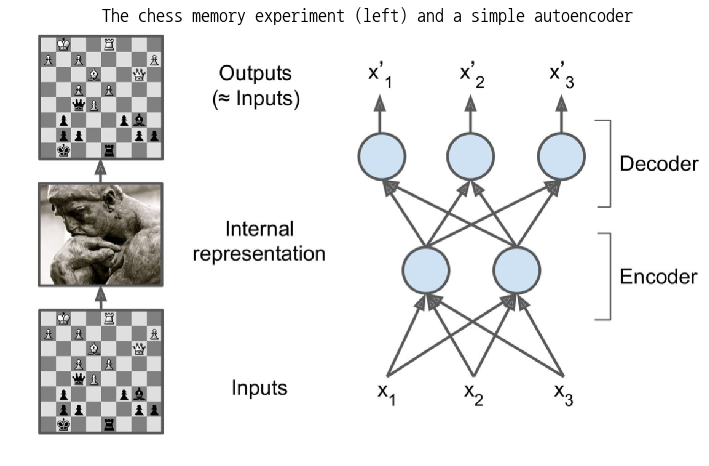

In [2]:
plt.figure(figsize=(12, 8))
plt.title("The chess memory experiment (left) and a simple autoencoder", fontsize=18)
plot_external2("./images/autoencoder/1.png")
plt.show()

그림에서 볼 수 있듯이 출력층의 뉴런 수가 입력 갯수와 동일하다는 것을 제외하면, 일반적으로 오토인코더는 다층 퍼셉트론(MLP)과 동일한 구조를 가집니다. 이 예에서는 2개의 뉴런으로 구성된 하나의 은닉층이 있습니다(인코더). 오토인코더가 입력을 재구성하기 때문에 출력을 종종 재구성(**reconstruction**)이라고 부릅니다. 비용 함수는 재구성이 입력과 다를 때 모델에 벌점을 부과하는 재구성 손실을 포함하고 있습니다. 오토인코더는 입력이 곧 타깃이 됩니다. 입력을 타깃으로 사용하는 이런 알고리즘을 일반적인 비지도 학습과 구분하여 자기 지도 학습이라고 부르기도 합니다.  

내부 표현이 입력 데이터보다 저차원이기 때문에(즉, 3차원 대신 2차원) 이런 오토인코더를 과소완전(**undercomplete**)이라고 합니다. 수학적 정의로 보면 bias보다 적은 갯수로 표현되는 것을 말하며 overcomplete는 그 반대의 경우입니다. 과소완전 오토인코더는 입력을 코딩으로 간단히 복사할 수 없으며, 입력과 똑같은 것을 출려갛기 위한 다른 방법을 찾아야 합니다. 이는 입력 데이터에서 가장 중요한 특성을 학습하도록 만듭니다(그리고 중요하지 않은 것은 버립니다).

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

<br><br>  

## 6.2 Performing PCA with an Undercomplete Linear Autoencoder

3D 데이터셋을 만듭니다:

In [5]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = (rnd.rand(m) * 3 * np.pi / 2) - 0.5
data = np.empty((m, 3))

data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

데이터를 정규화합니다:

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

오토인코더를 만듭니다:

In [7]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # 코딩 유닛
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model_path = "./models/06_autoencoder/01_LinearAutoencoder"
if not os.path.isdir(model_path):
    os.makedirs(model_path)
model_save_path = os.path.join(model_path, "my_model_linera_autoencoder")

In [9]:
n_iterations = 1000
codings = hidden
batch_size = 50
n_epoch = n_iterations // batch_size
history = {"batch_loss": []}

In [10]:
import sys
with tf.Session() as sess:
    init.run()
    for iteration in range(n_epoch):
        for i in range(batch_size):
            print("\r{}\t{:.3f}%".format(iteration+1, (i+1)/batch_size*100), end="")
            sys.stdout.flush()
            training_op.run(feed_dict={X: X_train})
    
        history_loss = sess.run(reconstruction_loss, feed_dict={X: X_train})
        history["batch_loss"].append(history_loss)
    
    codings_val = codings.eval(feed_dict={X: X_test})
    saver.save(sess, model_save_path)
    print(" epoch complete")

20	100.000% epoch complete


In [11]:
loss_ = history["batch_loss"]
epochs = range(1, len(loss_) + 1)

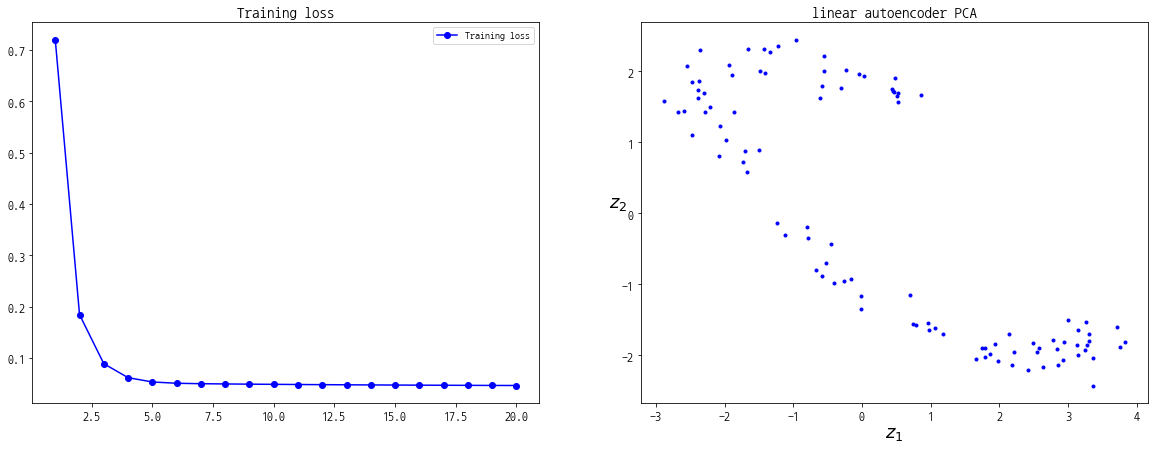

In [12]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.plot(epochs, loss_, "bo-", label="Training loss")
plt.title("Training loss")
plt.legend()

plt.subplot(122)
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.title("linear autoencoder PCA")
plt.show()

위의 결과는 원본 데이터셋의 loss와 오토인코더의 은닉층의 출력(즉, 코딩층, 오른쪽)을 보여줍니다. 여기서 볼 수 있듯이 오토인코더는 (PCA처럼) 데이터에 있는 분산이 가능한한 많이 보존되도록 데이터를 투영할 최상의 2D 평면을 찾습니다.

<br><br>

## 6.3 Stacked Autoencoders

다른 신경망과 마찬가지로 오토인코더도 여러 개의 은닉층을 가질 수 있습니다. 이런 경우를 **stacked autoencoder** 혹은 **deep autoencoder**라고 합니다. 층을 더 추가하면 오토인코더가 더 복잡한 코딩을 학습할 수 있습니다. 그러나 오토인코더가 너무 강력하게 되지 않도록 주의해야 합니다. 인코더가 너무 강력해서 각각의 입력 데이터를 임의의 한 숫자로 매핑하도록 학습했다고(그리고 디코더는 역으로 매핑하는 것을 학습했다고) 가정해보겠습니다. 당연히 이런 오토인코더는 훈련 데이터를 완벽하게 재구성하겠지만 이 과정에서 유용한 데이터 표현을 학습하지 못할 것입니다(그리고 새로운 샘플에 잘 일반화되지 않을 것입니다).  

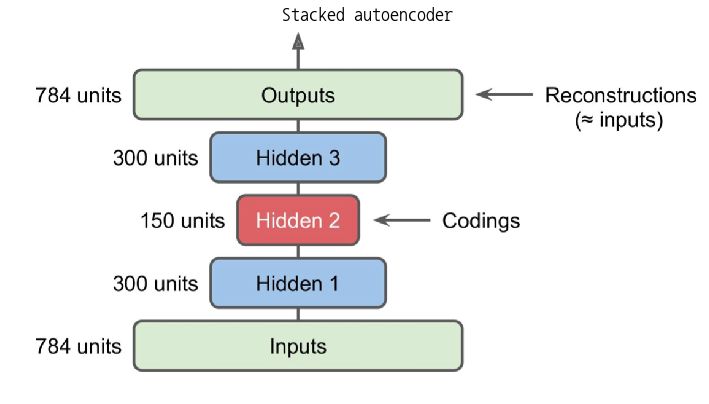

In [13]:
plt.figure(figsize=(12, 8))
plt.title("Stacked autoencoder", fontsize=18)
plot_external2("./images/autoencoder/3.png")
plt.show()

stacked autoencoders의 구조는 전형적으로 가운데 은닉층(코딩층)을 기준으로 대칭입니다. 간단히 말해 샌드위치 같은 모양입니다. 예를 들어 MNIST를 위한 오토인코더는 784개의 입력이 있고, 그 다음에 300개의 뉴런으로 된 은닉층, 그 다음에 150개 뉴런으로된 가운데 은닉층, 그 다음에 300개의 뉴런으로 된 은닉층, 그다음에 150개 뉴런으로 된 가운데 은닉층, 그다음에 300개의 뉴런으로 된 또 다른 은닉층, 마지막으로 784개의 뉴런으로된 출력층을 가집니다.

<br><br>

### 6.3.1 TensorFlow Implementation

In [14]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

stacked autoencoder는 평범한 심층 MLP와 매우 비슷하게 구현할 수 있습니다. 특히 심층 네트워크를 훈련시키기 위해 다양한 기법을 적용할 수 있습니다. 예를 들어 다음 코드는 HE 초기화, ELU 활성화 함수, $\ell_{2}$규제를 사용해 MNIST를 위한 stacked autoencoder를 만듭니다. 레이블이 없는(즉, y가 없는) 것을 제외하면 기존 머신러닝코드와 매우 비슷합니다.

In [15]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.variance_scaling_initializer() # He 초기화
#아래와 동일합니다:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



훈련은 다음과 같습니다(y_batch가 사용되지 않습니다). 이는 비지도 학습입니다.

In [16]:
model_path = "./models/06_autoencoder/02_Stacked_Autoencoders"
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [17]:
n_epochs = 5
batch_size = 150
history = {"loss": []}
model_save_path = os.path.join(model_path, "my_model_all_layers.ckpt")

In [18]:
import sys
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\repochs: {}, process: {:.2f}%".format(epoch + 1, 100 * (iteration+1) // n_batches), end="")
            sys.stdout.flush()                                         
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})  
        history["loss"].append(loss_train)
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)            
        saver.save(sess, model_save_path)                 

0 훈련 MSE: 0.02070144
1 훈련 MSE: 0.011539544
2 훈련 MSE: 0.01182476
3 훈련 MSE: 0.011682165
4 훈련 MSE: 0.011819371


In [19]:
loss_ = history["loss"]
epochs = range(1, len(loss_)+1)

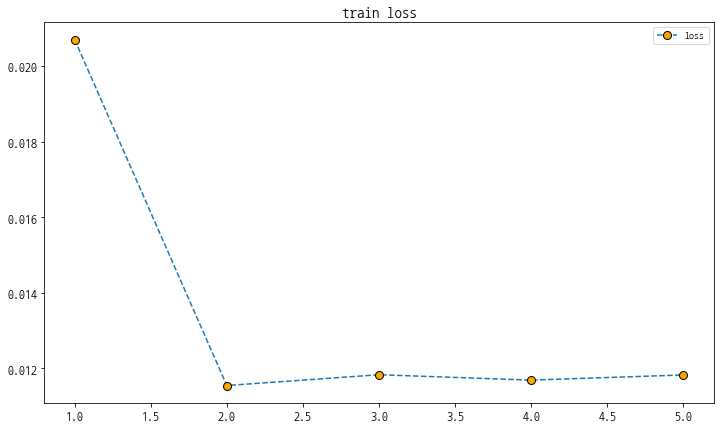

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(epochs, loss_, "o--", markersize=8, markeredgecolor= "k", markerfacecolor="orange",label = "loss")
plt.legend()
plt.title("train loss")
plt.show()

이 함수는 모델을 로드하고 테스트 세트에서 이를 평가합니다(재구성 오차를 측정합니다). 그런 다음 원본 이미지와 재구성 이미지를 그립니다:

In [21]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
            #         X_test = mnist.test.images[:n_test_digits]
            outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/06_autoencoder/02_Stacked_Autoencoders/my_model_all_layers.ckpt


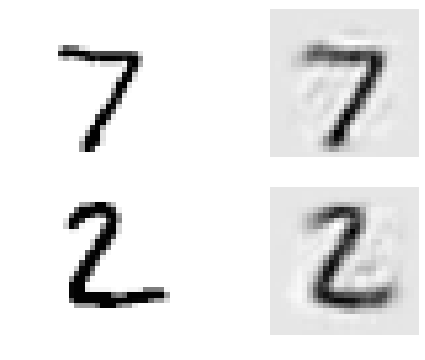

In [22]:
show_reconstructed_digits(X, outputs, model_save_path)

<br><br>

### 6.3.2 Tying Weights

위에서 만들었던 것처럼 오토인코더가 완벽하게 대칭일 땐 일반적으로 디코더의 가중치와 인코더의 가중치를 묶습니다. 이렇게 하면 모델에 있는 가중치의 수를 절반으로 줄여서 훈련 속도를 높이고 과대적합의 위험을 줄여줍니다. 구체적으로 말해 어떤 오토인코더가 (입력층은 제외한) $N$개의 층을 가지고 있고 $\mathbf{W}_{L}$이 $L$번째 층의 가중치를 나타낸다고 했을 때 (예를 들어 1은 첫번째 은닉층, $\frac{N}{2}$은 코딩층, $N$은 출력층) 디코더 층의 가중치는 $\mathbf{W}_{N-L+1} = {\mathbf{W}_{L}}^{T}$(여기서 $L = 1,\,2,\,\cdots ,\,\frac{N}{2}$)와 같이 간단하게 정의할 수 있습니다(코딩층을 기준으로 뉴런 수가 대칭이므로 출력층($L=N$)의 가중치 $\mathbf{W}_{1}$의 전치가 됩니다).

인코더와 디코더의 가중치를 묶는 일은 자주 있습니다(weights_decoder = tf.transpose(weights_encoder)). 안타깝지만 tf.layers.dense() 함수를 사용해서 이렇게 하기는 불가능합니다(또는 매우 어렵습니다). 수동으로 직접 오토인코더를 만들어야 합니다:

In [23]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [24]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

- 위 코드는 weights3와 weights4는 변수로 선언되지 않았고 각각 weights2와 weights1의 전치입니다(서로 묶여 있습니다).  
- 변수가 아니기 때문에 규제에 사용되지 않습니다. weights1과 weights2만 규제합니다.  
- 편향을 묶지도 않고 규제하지도 않습니다.

In [24]:
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [25]:
saver = tf.train.Saver()

In [26]:
model_path = "./models/06_autoencoder/03_Tying_Weights"
if not os.path.isdir(model_path):
    os.makedirs(model_path)
    
model_save_path = os.path.join(model_path, "my_model_tying_weights.ckpt")

In [31]:
n_epochs = 30
batch_size = 150
history = {"loss": []}

In [32]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\repoch: {}, process: {:.2f}% done".format(epoch+1, 100 * (iteration+1) // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        history["loss"].append(loss_train)
        
        if (epoch+1) % 5 == 0:
            print("\r{}".format(epoch+1), "훈련 MSE:", loss_train)
        saver.save(sess, model_save_path)

5 훈련 MSE: 0.018508332
10 훈련 MSE: 0.020868674
15 훈련 MSE: 0.0238289
20 훈련 MSE: 0.38367876
25 훈련 MSE: 0.20064865
30 훈련 MSE: 0.56096077


In [33]:
loss_ = history["loss"]
epochs = range(1, len(history["loss"])+1)

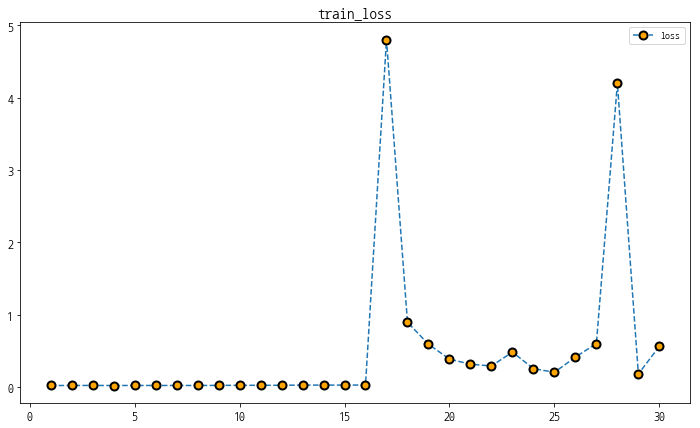

In [34]:
plt.figure(figsize = (12, 7))
plt.plot(epochs, loss_, "o--", label= "loss", markeredgecolor="k", markeredgewidth=2, markerfacecolor="orange", markersize=8)
plt.legend()
plt.title("train_loss")
plt.show()

<br><br>

### 6.3.3 Training One Autoencoder at a Time

앞서 했던 것처럼 한 번에 전체 오토인코더를 훈련시키는 것보다 아래 그림처럼 한 번에 오토인코더 하나를 훈련하고 이를 쌓아올려서 한 개의 stacked autoencoder를 만드는 것이 훨씬 빠릅니다. 이런 방식은 특히 아주 깊은 오토인코더일 경우에 유용합니다.

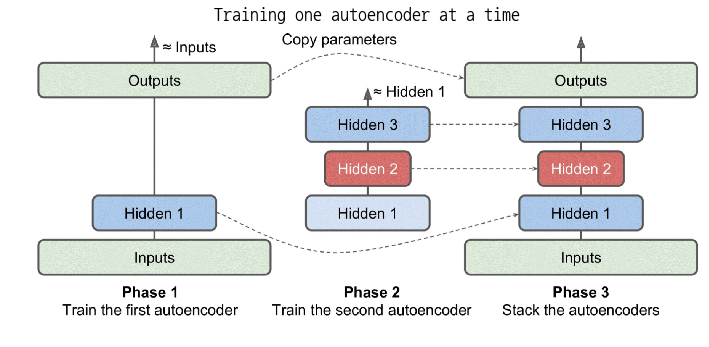

In [36]:
plt.figure(figsize=(12, 8))
plt.title("Training one autoencoder at a time", fontsize=18)
plot_external2("./images/autoencoder/4.png")
plt.show()

훈련 단계1에서 첫번째 오토인코더는 입력을 재구성하도록 학습됩니다. 단계 2동안에는 2번째 오토인코더가 첫 번째 오토인코더의 은닉층의 출력을 재구성하도록 학습됩니다. 마지막으로 위 그림처럼 모든 오토인코더를 사용해 전체 네트워크를 만듭니다(즉, 각 오토인코더의 은닉층을 먼저 쌓고, 그다음에 출력층을 올려놓습니다). 이렇게 해서 최종 적층 오토인코더를 만듭니다. 이런 방식으로 더 많은 오토인코더를 훈련시켜 아주 깊은 적층 오토인코더를 만들 수 있습니다.  

이런 다단계 훈련 알고리즘을 구현하는 가장 간단한 방법은 각 단계에서 다른 텐서플로 그래프를 사용하는 것입니다. 하나의 오토인코더 훈련이 끝나면 훈련 세트를 네트워크에 통과시켜 은닉층의 출력을 저장합니다. 이 출력이 다음 오토인코더의 훈련 세트가 됩니다. 모든 오토인코더가 이런 식으로 훈련을 마치면, 각 오토인코더의 가중치와 편향을 복사해서 적층 오토인코더를 만들면 됩니다. 